In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd 'drive/MyDrive/lab5/'

# !!!! TO load model from file tensorflow 2.8.0 is required !!!!

# tensorflow 2.4.1 will give JSONDecodeError

Mounted at /content/drive
/content/drive/MyDrive/lab5


## Import Packages

First, import modules for later use.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import math
import os
import os.path
from os import path
import tensorflow as tf
from tensorflow import keras
from data_loader import DataLoader

## Load Data
Downloaded dataset or batch files should be in the same directory as this notebook.

There are 50000 training images and 10000 test images. The training set is divided into five training batches, each with 10000 images. Each colour image has dimensions equal to 32 x 32 x 3 and there are 10 classes.

Both training and test set are perfectly balanced. 

In [2]:
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

X_train, y_train = DataLoader.load_batch('data_batch')
x_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

## Split data

Randomly split (85/15) the training images to training and validation set.

In [3]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

## Display randomly sampled images

In [4]:
def display(data, target, set_ran=True, pred_y=None):
    '''
    This function takes 4 parameters and show 20 randomly sampled images
    @param data: df contains data for the images
    @param target: true label for data 
    @param set_ran: if true, set random seed, otherwise ouput random image each time when the function's called
    @param pred_y: predicted label, should be same shape/size as target param
    '''
    if set_ran:
        random.seed(41)

    random_img = np.array(random.sample(range(data.shape[0]), 20)).reshape(5,4)
    fig, ax = plt.subplots(5,4, figsize= (10,10))
    for i in range(5):
        for j in range(4):
            ax[i,j].imshow(data[random_img[i,j]], cmap="binary", interpolation="nearest")
            if pred_y is not None:
                ax[i,j].set_title(class_names[target[random_img[i,j]]], 
                                  color=("green" if pred_y[random_img[i,j]] == target[random_img[i,j]] else "red"))
            else:
                ax[i,j].set_title(class_names[target[random_img[i,j]]])
            ax[i,j].axis("off")
    plt.show()

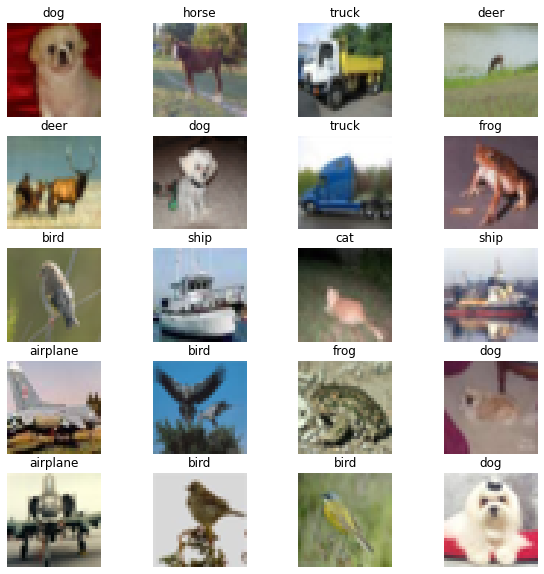

In [5]:
# random images from training set
display(x_train, y_train)

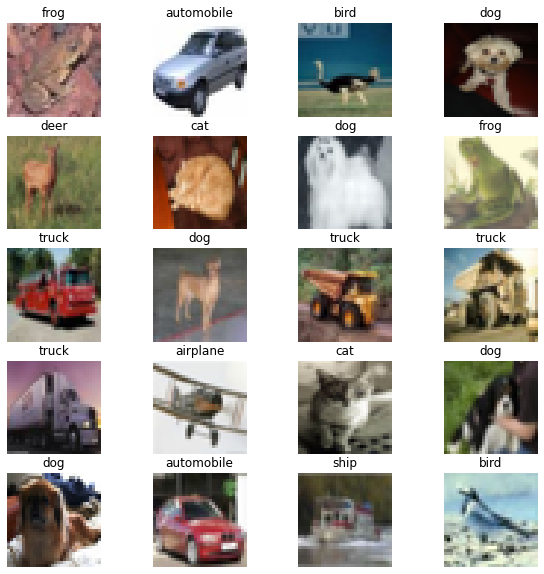

In [6]:
# random images from validation set
display(x_val, y_val)

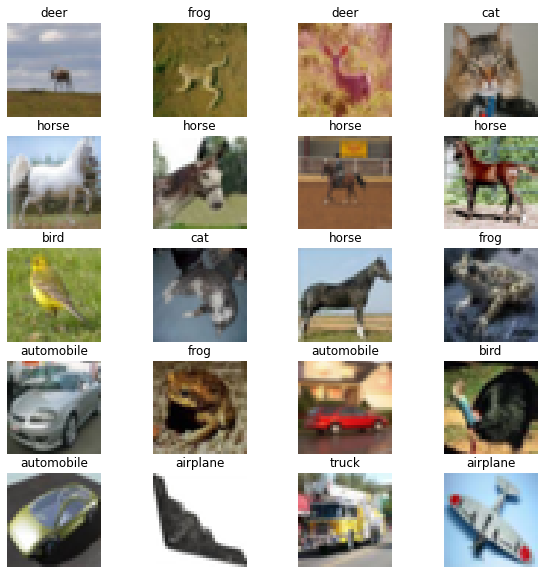

In [7]:
# random images from test set
display(x_test, y_test)

## MLP- Training

Parameters that stayed the same during tuning processs:

- The activation function was used to modify the data in a non-linear way. This non-linearity allows to spatially modify the representation of the data and relu was picked for this model since it is the most used activation function by default with reasonable performance, and it is fast to compute. Activation function for last layer is 'softmax' since this is a multicalssification problem.

- sparse_categorical_crossentropy was used as the loss function because the classes are completely mutually exclusive, and we have sparse labels for this dataset.

- The goal of optimization is to efficiently calculate the parameters/weights that minimize this loss function. Stochastic Gradient Descent was used as the optimizer so Keras will perform the backpropagation algorithm.

- Since this is a classification task, accuracy was used as the metrics to be evaluated by the model during training. 

- EarlyStopping was used as a regularization to avoid overfitting, if the val_accuracy does not improve in the next 10 epoch, then stop training.

- ModelCheckpoint is a callback to save the model, only save best model in the model training process.

### Model tuning process 

(Code for fine tuning process can be found in the next section)

Parameters for tuning:

- learning rate schedule: Three learning rate schedule functions were created. They were passed in the LearningRateScheduler callback (repeated-one at a time) that updated learning rate value based on the schedule function. 

- kernel initializers: define the way to set the initial connection weights of Keras layers. kernel_initializer="uniform" means uniform distribution will be used to initialise the weights.
   
- dropout rate: regularisation parameter that randomly sets input units to 0 with a frequency of rate at each step. Range from 0 and 1, the higher the dropout rate the greater the regularisation.

The model was first trained with three hidden layers with default hyperprameters and the accruacy on training set was greater than 0.9 and validation accuracy was around 0.5 (overfitting). Thus, hypeparameters must be tuned to avoid overfitting and need to find the best parameter values that give higher accuracy. 

Gird search (sklearn) was performed with two hyperparameters (dropout rate and kernel_initializer) on validation set. This process repeated with different learning rate schedule callbacks. Best parameters and best score were obtained from grid search best_params_ and best_score_ attributes. <br>
To use the keras model in scikit-learn, KerasClassifier class must be used to wrap the model. A function creates and returns sequential model was defined to use these wrappers. This function was passed to the build_fn argument when constructing the KerasClassifier class. The constructor for the KerasClassifier class can take default arguments that are passed on to the calls to model.fit(), such as the number of epochs and it was set 100 as per requirement. Once the model's wrapped and it passed in to the GridSearchCV constructor. A dictionary containing two hyperparameters (init_mode and dropout_rate) passed in the param_grid argument to evaluate.

Based on the results from gridsearch, the model was then trained with 4 dense layer(3 hidden and one output layer), with kernel_initializer="uniform", a dropout rate of 0.2 between dense layers and used the third learning rate schedule (basically learning rate decrease expotentially based on the number of epoch, see next section for commented out code). The input layer has 32x32x3=3072 neurons, so the first hidden layer was nearly halfed with 1500 neurons, the second hidden layer had 750 neurons and the third hidden layer had 375 neurons and the output layer had 10 neurons which corresponds to 10 classes.

When the dropout rate was set to 0.2, the accuracy on training set was 0.7109 while the val_accuracy was 0.5628 suggesting there was a overfitting issue. So dropout rate was increased to 0.3 (increase regularisation) and the accuracy on training set had dropped to 0.6213 and val_accuracy was 0.5428. The model was still overfitting and to overcome this, model complexity was decreased instead of increase dropout value and this was done by removing one hidden layer and reducing the number of neurons to make the network less prone to overfitting as the neurons contributing to overfitting are removed or deactivated. Therefore, the network has a smaller number of parameters to learn because of which it cannot memorize all the data points and will be forced to generalize.

Custom Gridsearch was performed with one less hidden layer and less neurons (300 for the first hidden layer and 150 for the second hidden layer) using nested for loops to find optimal dropout rate and kernel initializer. The results was {'dropout': 0.2, 'kernel_initializer': 'uniform'}, and validation accuracy was 0.5434. Models were then manually tuned with:

dropout rate of 0.2: 

kernel_initializer=uniform & third learning rate scheduler       (accuracy: 0.5964, val_accuracy: 0.5403) 

kernel_initializer=uniform & first learning rate scheduler       (accuracy: 0.6284, val_accuracy: 0.5481)

kernel_initializer=lecun_uniform & first learning rate scheduler (accuracy: 0.5087, val_accuracy: 0.5035)

kernel_initializer=normal & first learning rate scheduler        (accuracy: 0.5598, val_accuracy: 0.5199)  
                     
dropout rate of 0.3: 

kernel_initializer=uniform & third learning rate scheduler       (accuracy: 0.5449, val_accuracy: 0.5228)

kernel_initializer=uniform & first learning rate scheduler       (accuracy: 0.5684, val_accuracy: 0.5303)  

After compared the output, the final model was trained with the third learning rate schedule, dropout rate of 0.3 and used uniform as the kernel_initializer.

### Model tuning (Code)

**Grid search (sklearn) for dropout rate and initial weight connection using validation set**

In [8]:
# keras.backend.clear_session()
# np.random.seed(42)
# tf.random.set_seed(42)

# #Learning rate schedule
    
# # drop the learning rate by a factor every 5 epochs - first learning rate shcedule
# def step_decay(epoch):
#    initial_lr = 0.1 
#    drop = 0.5<br>
#    epochs_drop = 5.0
#    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
#    return lr

# # drop learning rate expotentially by k  - second learning rate shcedule
# def exp_decay(epoch): 
#    initial_lr = 0.1
#    k = 0.1
#    lr = initial_lr * tf.math.exp(-k)
#    return lr

# # drop learning rate expotentially by number of epoch - third learning rate shcedule
# def scheduler(epoch):
#   lr = 0.1
#   return lr * tf.math.exp(-0.1*epoch)

# # Learning schedule callbacks

# lr1 = tf.keras.callbacks.LearningRateScheduler(step_decay) 
# lr2 = tf.keras.callbacks.LearningRateScheduler(exp_decay)
# lr3 = tf.keras.callbacks.LearningRateScheduler(scheduler) 

# # early stopping callback
# es =  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

# # checkpoint callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint("./Yin_Xiaoyu_MLP/Yin_Xiaoyu_MLP.h5", save_best_only=True)

In [9]:
# # function that create the model
# def create_model(init_mode="uniform", dropout_rate=0):
#     model = keras.models.Sequential() 
#     model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
#     model.add(keras.layers.Dense(1500, kernel_initializer=init_mode, activation="relu"))
#     model.add(keras.layers.Dropout(dropout_rate))
#     model.add(keras.layers.Dense(750, kernel_initializer=init_mode, activation="relu"))
#     model.add(keras.layers.Dropout(dropout_rate))
#     model.add(keras.layers.Dense(375, kernel_initializer=init_mode, activation="relu"))
#     model.add(keras.layers.Dropout(dropout_rate))
#     model.add(keras.layers.Dense(10, kernel_initializer=init_mode, activation="softmax"))
#     model.compile(loss="sparse_categorical_crossentropy",
#               optimizer=keras.optimizers.SGD(),
#               metrics=["accuracy"])
#     return model

# ## Wrapper before grid search
# from keras.wrappers.scikit_learn import KerasClassifier 
# keras_cf = KerasClassifier(build_fn=create_model, epochs=100, verbose=0)

In [10]:
# from sklearn.model_selection import GridSearchCV

# param = {  
#     "init_mode": ['uniform', 'lecun_uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
#     "dropout_rate": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
# }

# grid_search_cv = GridSearchCV(keras_cf, param, n_jobs=-1, cv=3)

## grid search was repeated with different learning rate schedular with the same param

# grid_search_cv1.fit(x_val, y_val,callbacks=[lr1],verbose=2)

# grid_search_cv2.fit(x_val, y_val,callbacks=[lr1],verbose=2)

# grid_search_cv3.fit(x_val, y_val,callbacks=[lr3],verbose=2)

# # get the best params and score 
# grid_search_cv1.best_params_
# grid_search_cv1.best_score_

**Custom GridSearch for dropout rate, initial weight connection and learning rate schedule**

In [11]:
# params = {"dropout":[0.2, 0.3], "kernel_initializer": ["uniform", "normal"]}
# best_val_accuracy = 0
# best_params = {"dropout":0, "kernel_initializer": ""}

# for d in range (2):
#     for k in range (2):
#         mlp = keras.models.Sequential([
#             keras.layers.Flatten(input_shape=[32, 32, 3]),
#             keras.layers.Dense(300, kernel_initializer=params["kernel_initializer"][k], activation="relu"),
#             keras.layers.Dropout(params["dropout"][d]),
#             keras.layers.Dense(150, kernel_initializer=params["kernel_initializer"][k], activation="relu"),
#             keras.layers.Dropout(params["dropout"][d]),
#             keras.layers.Dense(10, kernel_initializer=params["kernel_initializer"][k], activation="softmax") 
#         ])

#         mlp.compile(loss="sparse_categorical_crossentropy",
#               optimizer=keras.optimizers.SGD(),
#               metrics=["accuracy"])

#         history = mlp.fit(x_train, y_train, epochs=100,validation_data=(x_val, y_val),callbacks=[lr3, es], verbose=0)

#         val_accuracy = max(history.history['val_accuracy'])

#         if val_accuracy > best_val_accuracy : 
#             best_val_accuracy = val_accuracy
#             best_params["dropout"] = params['dropout'][d]
#             best_params["kernel_initializer"] = params['kernel_initializer'][k]

### Final model

In [12]:
# callbacks
# def scheduler(epoch):
#     lr = 0.1
#     return lr * tf.math.exp(-0.1*epoch)

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
# es =  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [13]:
# checkpoint_cb = keras.callbacks.ModelCheckpoint("Yin_Xiaoyu_MLP", save_best_only=True)
# mlp = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[32, 32, 3]),
#     keras.layers.Dense(300, kernel_initializer="uniform", activation="relu"),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(150, kernel_initializer="uniform", activation="relu"),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(10, kernel_initializer="uniform", activation="softmax") 
# ])

# mlp.compile(loss="sparse_categorical_crossentropy",
#               optimizer=keras.optimizers.SGD(),
#               metrics=["accuracy"])

In [14]:
# history = mlp.fit(x_train, y_train, epochs=100,validation_data=(x_val, y_val),
#                                 callbacks=[lr_schedule, es, checkpoint_cb])
# # find the learning rate for best model
# lr = history.history['lr'][history.history['val_accuracy'].index(max(history.history['val_accuracy']))]

## CNN

CNN automatically learns data using the different layers which has filters and combines the results of these filters to predict the class the input image. Unlike an MLP, the neurons in a CNN convolutional layer are not connected to all other neurons, but connected only to a small region of neurons in the previous layer. Polling layer is used as an intermediate layer in the network to downsamples the previous layer’s feature maps obtained from different filters to reduce over-fitting and computations in the network. The batch nornalisation layer that normalize the output of the previous layers used as regularization to avoid overfitting of the model. As in MLP, the fully connected layer (dense layer) in a CNN has neurons that are fully connected to the neurons in the previous layer.

Paramters stayed the same during tuning:

- padding="same": the convolutional layer uses zero padding if necessary. In this case, the number of output neurons is equal to the number of input neurons divided by the stride. Then zeros are added as evenly as possible around the inputs.

- learning rate schedule: see MLP above

- loss, optimizer, metrics: same as MLP

- activation for first fully connected layer: "relu"

- activation for second fully connected layer (output layer): same as MLP


### Model Tuning process

Instead of using sklearn grid search, the tuning process for CNN was done using custom gridsearch and manual tuning .

kernel size: height and width of the 2D convolution window
filters: dimensionality of the output space

The initial model used 2 convolutional layers with 32 filters and 3 kernel size for the first layer and 64 filters and 3 kernel size for the second layer. Both layer used the relu as the activation function and 'same' for the padding. The model then followed by 1 flatten layer, pooling layer and batch norm layer, then dropout 30%, then a dense layer with 128 neurons and used relu as the activation function, another dropout layer with 30% dropout, and finally the output layer with 10 neurons and 'softmax' as the activation fucniton. The model's accuracy were 0.6720 and 0.6968 on training and validation set, respectively. It performed much better than MLP model. However, we still want to see if the accuracy could be improved by change the number of filters and kernel size.  

The second model was then modified by change the activation function for the first 2 convolutional layers to 'selu', everthing else stayed the same as the initial model and the accuracy was 0.7593 for training set and 0.7459 for validation set. Obviously, 'selu' outperformed 'relu'.

Custom search was then performed. Three variables were defined: params contains the value for hyperparameters (filter number and kernel size, no activation function, because from above experimentation, it's clear that 'selu' performs better that 'relu'), best_val_accuracy stores the best validation accuracy value and best_params stores the parameter values that yield the best validation accuracy. Nested for loops that'd built model based on the params. After the code chunk was executed, best_params was {'filternumber': 32, 'kernel_size': 3} and best_val_accuracy was 0.7444. The validation accuracy for this model was slightly less than the second model above. 

Maunal tuning:

The third model was build built using 'selu' as the activation function and changed the number of filters for first convolutional layer to 64. However, there was no improvement on accuracy on validation set (0.7617 and  0.7424 accuracy for training and validation set, respectively.)

The fourth model was built by change the second convolutional layer's kernel size to 4 and 'selu' was used as the activation function. It performed slightly worse than the second model with an accuracy of 0.7422 and 0.7343 for training and validation set.

Overall, the second model had the highest validation accuracy, so the final model was built based on this. 

In [15]:
# params = {"filter_num":[32, 64], "kernel": [3, 4]}
# best_val_accuracy = 0
# best_params = {"filternumber": 0, "kernel_size":0}

# for i in range (2):
#     for j in range (2):
#         cnn = keras.models.Sequential([
#             keras.layers.Conv2D(params['filter_num'][j], kernel_size=params['kernel'][i], padding="same", activation="selu", input_shape=[32,32,3]),
#             keras.layers.MaxPool2D(),
#             keras.layers.Conv2D(params['filter_num'][j], kernel_size=params['kernel'][i], padding="same", activation="selu"),
#             keras.layers.MaxPool2D(),

#             keras.layers.Flatten(),

#             keras.layers.BatchNormalization(),
#             keras.layers.Dropout(0.3),
#             keras.layers.Dense(128, activation="relu"),
#             keras.layers.Dropout(0.3),
#             keras.layers.Dense(10, activation="softmax")
#         ])

#         cnn.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(),
#                   metrics=["accuracy"])

#         history = cnn.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, lr3], verbose=0)

#         val_accuracy = max(history.history['val_accuracy'])

#         if val_accuracy > best_val_accuracy : 
#             best_val_accuracy = val_accuracy
#             best_params["filternumber"] = params['filter_num'][j]
#             best_params["kernel_size"] = params['kernel'][i]
            
# print(best_params, best_val_accuracy)

### Final Model

In [16]:
# cnn = keras.models.Sequential([
#     keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu", input_shape=[32,32,3]),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
#     keras.layers.MaxPool2D(),
    
#     keras.layers.Flatten(),
    
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.3),
#     keras.layers.Dense(10, activation="softmax")
# ])

# cnn.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(),
#               metrics=["accuracy"])

# checkpoint_cnn = keras.callbacks.ModelCheckpoint("Yin_Xiaoyu_CNN", save_best_only=True)

In [17]:
# history = cnn.fit(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[es, lr_schedule, checkpoint_cnn])

## Evaluate model on test set

In [18]:
def scheduler(epoch):
    '''
    this function return the learning rate based on epoch
    '''
    lr = 0.1
    return lr * tf.math.exp(-0.1*epoch)

def one_epoch_lr(epoch):
    '''
    constant learning rate
    use this when model's loaded from dir
    Didn't use the the lr from the best model(it's not small enough for reproducible results)
    '''
    return 0.000001

# earling stopping nad learning rate schedule callbacks
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
one_epoch_lr = keras.callbacks.LearningRateScheduler(one_epoch_lr)
es =  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

In [19]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# helper functions that will be used to evaluate both model

def pred(model,x_train,x_test):
    '''
    Takes 3 parameters
    @param model: model to make prediction
    @param x_train: training set 
    @param x_test: test set
    '''
    train_pred = np.argmax(model.predict(x_train), axis=-1)
    test_pred = np.argmax(model.predict(x_test), axis=-1)
    return train_pred, test_pred

def performance(x, y, pred_y, model):
    '''
    Takes 4 parameters and return accuracy and f1 score 
    @param model: model to evaluate 
    @param x: df without label 
    @param y: label for df
    @param model: model to x,y 
    
    '''
    acc = model.evaluate(x, y, verbose=0)[1]
    fl = f1_score(y, pred_y, average="micro")
    return acc, fl

def train_test_perf(train_per, test_per, modelname):
    #take 2 list of performance and return data frame
    data = {'training-'+modelname :train_per, 'testing-'+modelname:test_per}
    return pd.DataFrame(data, index =['accuracy','f1'])

def matrix(y_true, y_pred, class_names=class_names):
    '''
    Takes 3 parameters and display confusion matrix table
    @params y_true: true label
    @params y_pred: predicted label
    @params class_names: label for classes
    '''
    mx = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(mx, display_labels=class_names) 
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax)

### MLP

If model is not present in subdirectory, train the model otherwise load the model.

The model has 6 layers in total, one flatten layer that convert data to 1-dimensional vectors, then followed by 3 dense layer (2 hidden layers and 1 output layer) and 2 dropout layers between dense layers with a rate of 0.3.

There are total of 968560 trainable parameters for this model. These are the parameters are those which value is adjusted/modified during training as per their gradient. 

There is no non-trainable parameters. Non trainable parameters are those which value is not optimized during the training as per their gradient

In [20]:
mlp_path = 'Yin_Xiaoyu-MLP'

# checkpoint callback, only save the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(mlp_path, save_best_only=True)

if not path.exists(mlp_path):

    # set up the model
    mlp = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[32, 32, 3]),
        keras.layers.Dense(300, kernel_initializer="uniform", activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(100, kernel_initializer="uniform", activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10,  kernel_initializer="uniform", activation="softmax") 
    ])

    mlp.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=["accuracy"])

    # model architecture 
    mlp.summary()

    # train the model
    mlp_history = mlp.fit(x_train, y_train, epochs=100,
                    validation_data=(x_val, y_val),
                    callbacks=[lr_schedule, es, checkpoint_cb])
    # rollback to the best model 
    mlp = keras.models.load_model(mlp_path)
else:
    # load the model from file
    mlp = keras.models.load_model(mlp_path)

    # model architecture 
    mlp.summary()
    
    # train for one epoch
    mlp.fit(x_train, y_train, epochs=1, validation_data=(x_val, y_val), callbacks=[one_epoch_lr])

2022-05-27 23:21:07.693654: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 300)               921900    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 953,010
Trainable params: 953,010
Non-trai

#### Comapre MLP performance on training and test set

The accuracy for training set is higher than the output accuracy when the model's trained with one epoch, this the probably because the model has memorised the training data since the model's trained with training set.

The accuracy and f1 score on training set is higher than the accuracy and f1 score on test set.

Overall, by looking at the classification report, the trained mlp model performed better on training set as compared to test set for all 10 classes. The prediction pattern is same between training and test set. The model is better at correctly classify automobile and ship. This is probbaly because they are more distinct from other classes. The model generally performs bad for bird, cat, deer and dog (maybe because there are all samll and with similar physical appearance) and has a simialr performance for other classes.

Looking at the confusion matrix(cm) closely and classification report for the test set, the diagonal of cm shows the number images that correctly classified. We can see that airplanes mostly misclassified as ship vice versa, automobile mostly misclassified as truck vice versa, bird mostly misclassified as cat deer and frog. What we can see from this is that when one class that more distinct features as comapre to other classes, the higher the f1 score. 

In [21]:
mlp_train_pred, mlp_test_pred = pred(mlp,x_train,x_test)
mlp_train_per = performance(x_train, y_train, mlp_train_pred, mlp)
mlp_test_per = performance(x_test, y_test, mlp_test_pred, mlp)
train_test_perf(mlp_train_per,mlp_test_per,"mlp")

,training-mlp,testing-mlp
accuracy,0.591906,0.5283
f1,0.591906,0.5283


In [22]:
print(classification_report(y_train, mlp_train_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.67      0.60      0.63      4279
  automobile       0.69      0.74      0.71      4266
        bird       0.50      0.37      0.43      4231
         cat       0.42      0.45      0.44      4232
        deer       0.53      0.50      0.51      4296
         dog       0.51      0.43      0.47      4237
        frog       0.57      0.71      0.63      4251
       horse       0.67      0.69      0.68      4245
        ship       0.69      0.74      0.72      4229
       truck       0.63      0.68      0.66      4234

    accuracy                           0.59     42500
   macro avg       0.59      0.59      0.59     42500
weighted avg       0.59      0.59      0.59     42500



In [23]:
print(classification_report(y_test, mlp_test_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.61      0.56      0.59      1000
  automobile       0.61      0.65      0.63      1000
        bird       0.45      0.33      0.38      1000
         cat       0.36      0.38      0.37      1000
        deer       0.46      0.44      0.45      1000
         dog       0.46      0.37      0.41      1000
        frog       0.51      0.66      0.58      1000
       horse       0.59      0.59      0.59      1000
        ship       0.63      0.69      0.66      1000
       truck       0.56      0.60      0.58      1000

    accuracy                           0.53     10000
   macro avg       0.52      0.53      0.52     10000
weighted avg       0.52      0.53      0.52     10000



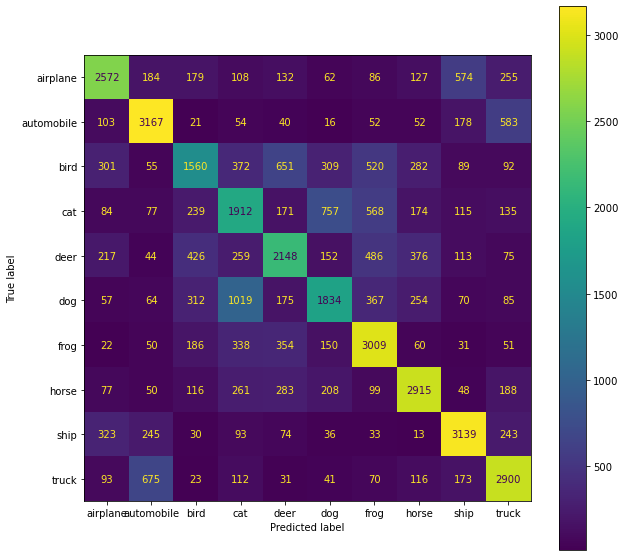

In [24]:
matrix(y_train, mlp_train_pred)

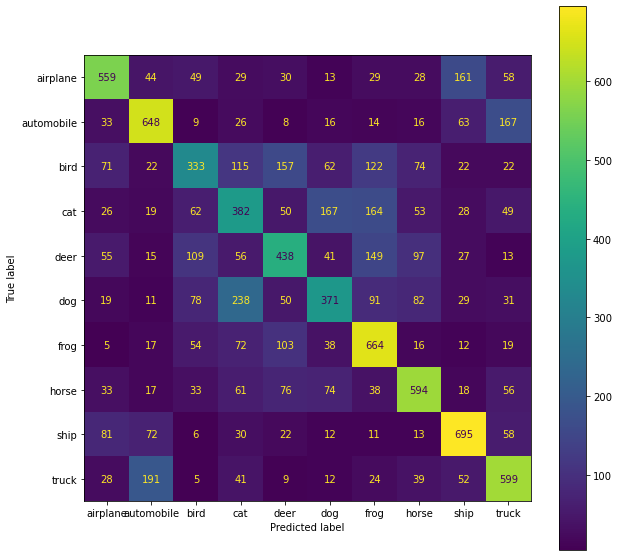

In [25]:
matrix(y_test, mlp_test_pred)

### CNN

Same as MLP above, if model is not present in subdirectory, train the model for 100 epoch otherwise load the model.

The model has 10 layers in total:

• The first layer is a convolutional layer with a kernel size of 3, but no stride because the input images are not very large. It also sets input_shape=[32, 32, 3], which means the images have a dimension of 32 × 32 x 3. 

• Next, we have a max pooling layer with default pool dize which divides each spatial dimension by a factor of two.

• Then we repeat the same structure once: 1 convolutional layers with more filters(64) followed by 1 pooling layer. 

• Next is flatten layer that change the ouput to vector.

• Then we have a batch normalization layer that normalise output (maintain mean output close to 0 and the output standard deviation close to 1.) and a dropout layer that deactivate 30% of units.

• Next is the fully connected network, composed of a hidden dense layers and a dense output layer. Dropout layers was added with a dropout rate of 30% each, to reduce overfitting


There are total of 561,482 parameter, 553,290 trainable parameters and  8,192 of non-trainable params.

In [26]:
cnn_path = "Yin_Xiaoyu-CNN"
checkpoint_cnn = keras.callbacks.ModelCheckpoint(cnn_path, save_best_only=True)

if not path.exists(cnn_path): 
    
    # set up the model
    cnn = keras.models.Sequential([
        keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="selu", input_shape=[32,32,3]),
        keras.layers.MaxPool2D(),
        keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="selu"),
        keras.layers.MaxPool2D(),

        keras.layers.Flatten(),

        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(10, activation="softmax")
    ])

    # compile the model
    cnn.compile(loss="sparse_categorical_crossentropy", optimizer=tf.keras.optimizers.SGD(), 
                metrics=["accuracy"])

    # model architecture 
    cnn.summary()

    # train the model
    cnn_history = cnn.fit(x_train, y_train, epochs=100, 
                                   validation_data=(x_val, y_val), 
                                   callbacks=[es, checkpoint_cnn, lr_schedule])
    # rollback to the best model
    cnn = keras.models.load_model(cnn_path)

else:
    # load the model
    cnn = keras.models.load_model(cnn_path)

    # model architecture 
    cnn.summary()

    # train for one epoch
    cnn_history = cnn.fit(x_train, y_train, epochs=1, 
                    validation_data=(x_val, y_val),
                    callbacks=[one_epoch_lr])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 batch_normalization (BatchN  (None, 4096)            

#### Comapre CNN performance on training and test set

Again, same as MLP model above, the global accuracy and f1 score on training set is higher than the accuracy and f1 score on test set ( around 87% VS 74%). The global accuracy score on test set is very close to the accuracy on validation set (around 74%).

The trained CNN model performed better on training set as compared to test set for all 10 classes based on classification report. The prediction pattern is same between training and test set (same as mlp again). The accuracy and f1 score for bird, cat and dog were simialr and lower than other 7 classes.

Looking at the cm for test set, the accuracy (it's obvious without the actual results since all 10 classes have 1000 images) for test set, the accuracy for truck, ship, frog, and automobile are similar (greater than 80%- which means more than 80% of the images from those classes classified correctly.), accuracy for dear, horse and airplane are simiar (ranged from 75%-79%). Class cat has the lowerst accuracy (around 50%),  model's performance on bird and dog (58%, 65%) are better than cat.

In [27]:
cnn_train_pred, cnn_test_pred = pred(cnn,x_train,x_test)
cnn_train_per = performance(x_train, y_train, cnn_train_pred, cnn)
cnn_test_per = performance(x_test, y_test, cnn_test_pred, cnn)
train_test_perf(cnn_train_per,cnn_test_per, "cnn")

,training-cnn,testing-cnn
accuracy,0.852,0.7338
f1,0.852,0.7338


In [28]:
print(classification_report(y_train, cnn_train_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.88      0.87      0.88      4279
  automobile       0.94      0.93      0.94      4266
        bird       0.83      0.74      0.78      4231
         cat       0.74      0.69      0.71      4232
        deer       0.75      0.88      0.81      4296
         dog       0.77      0.75      0.76      4237
        frog       0.87      0.91      0.89      4251
       horse       0.90      0.89      0.89      4245
        ship       0.92      0.93      0.93      4229
       truck       0.91      0.93      0.92      4234

    accuracy                           0.85     42500
   macro avg       0.85      0.85      0.85     42500
weighted avg       0.85      0.85      0.85     42500



In [29]:
print(classification_report(y_test, cnn_test_pred, target_names=class_names))

              precision    recall  f1-score   support

    airplane       0.77      0.77      0.77      1000
  automobile       0.84      0.85      0.84      1000
        bird       0.68      0.56      0.62      1000
         cat       0.57      0.53      0.55      1000
        deer       0.65      0.75      0.69      1000
         dog       0.61      0.63      0.62      1000
        frog       0.77      0.84      0.80      1000
       horse       0.80      0.79      0.79      1000
        ship       0.83      0.83      0.83      1000
       truck       0.81      0.79      0.80      1000

    accuracy                           0.73     10000
   macro avg       0.73      0.73      0.73     10000
weighted avg       0.73      0.73      0.73     10000



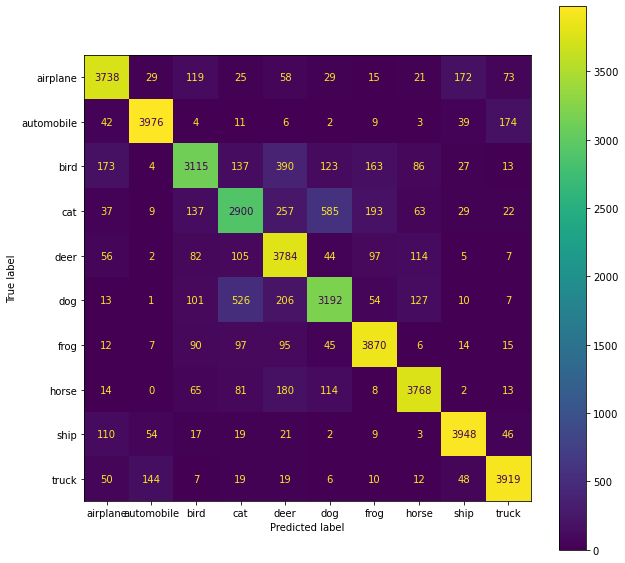

In [30]:
matrix(y_train, cnn_train_pred)

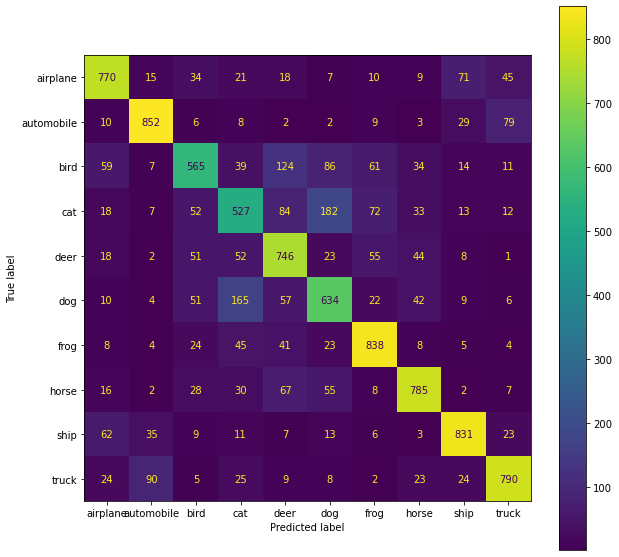

In [31]:
matrix(y_test, cnn_test_pred)

## Compare MLP and CNN

Based on results abve, it is clear that CNN (≃75% accuracy) outperformed MLP(≃53% accuracy). When we look at these two MLP and CNN's confusion matrices, we can see that number of correctly classfied images for each class is higher for CNN model as compared with MLP. Also, if we look at the classification report for both model and compare the precision, recall, and f1 score between MLP and CNN for each class, it's clear that CNN perform better for all classes.

The prediction pattern is similar between these two models. Both model didn't perfrom well for `bird`, `cat` and `dog` classes. Most misclassification are find in those three classes, this probably because they share too much common features (eg., size, weight).

MLP has more trainable paramters(968,560) as compared to the CNN which has 553,290 trainable paramters. MLP processes inputs in a different way than CNN. The images data need to converted to 1-dimensional vectors and this increases the number of trainable parameters exponentially and may easily leads to over-fitting since the data is flattened into a vector of 32x32x3 = 3072 rows so the MLP must have 3072 weights in its first layer to receive this input vector,  while this flattening of input is not required for CNN.  Since MLP takes vector as input and CNN takes tensor as input so CNN can understand spatial relation (relation between nearby pixels of image) between pixels of images better and this might be the case why CNN perfrom better than MLP.

From the model architecture, we can see that CNN has more layers than MLP and this may explain why it took a little longer time to train the CNN model (5 to 7 mins with early stopping or 6s per epoch) than MLP (3 to 4 mins with early stopping or 4s per epoch).

For the below two graphs*, labels that are shown in red means the images have been miscalssified by the model. The images that are misclassified by CNN are also misclassifed by MLP. There are 8/20 images misclassfied by MLP model, 3/20 are misclassfied by CNN model and this further demonstrated that CNN outperfrom MLP. Both model misclassified images at row1 column2 (deer), row2 column3(horse). The reason for this could be the animals look small on the image (pictures may be taken from long distance) and correctly classified horses look much larger than the misclassified one.

*When model's loaded, the predicted lable may be different. If no misclassified images present, please set the set_ran parameter of the display function to False and run the code again.


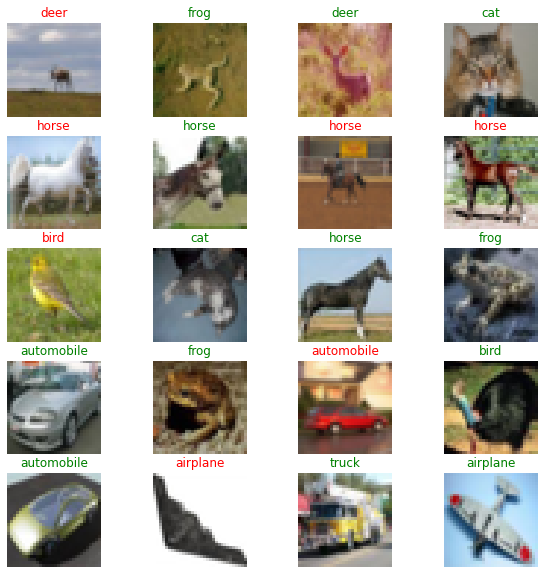

In [32]:
display(x_test, y_test, pred_y=mlp_test_pred)

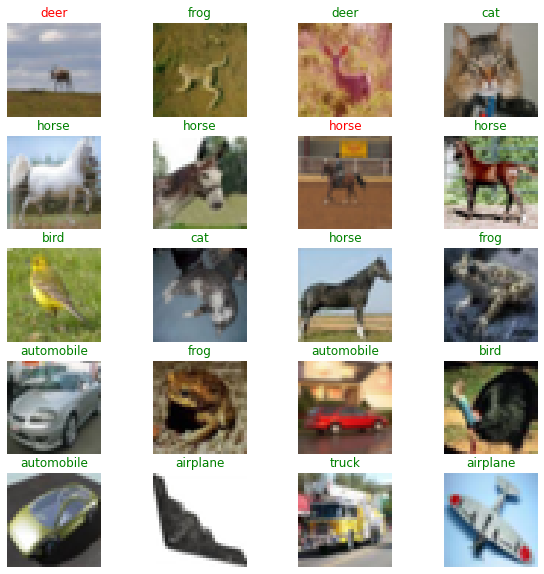

In [33]:
display(x_test, y_test, pred_y=cnn_test_pred)